# Time Series Pre-Modeling Data Checks
### Electricity Demand Forecasting — Monthly KWh Data (2019–2026)
---
This notebook walks through **14 pre-modeling data checks** before building a classical SARIMA time series model for electricity demand forecasting.

## 📦 Imports & Setup

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from statsmodels.tsa.stattools import adfuller, kpss, acf, pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from itertools import product
from scipy import stats
import calendar
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
plt.rcParams['figure.figsize'] = (14, 5)
plt.rcParams['axes.grid'] = True
plt.rcParams['grid.alpha'] = 0.3

## 📂 Data Loading

In [4]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/tgnpdcl/tgnpdcl_domestic_agg_data.csv')
df["month_year"] = df["source_file"].str.extract(r'([A-Z]+-\d{4})')

df["month_year"] = pd.to_datetime(df["month_year"])



In [5]:
df1 = df.groupby("month_year")["Units"].sum().reset_index()
df1.columns = ["month_year", "total_units(KWh)"]

df1

,month_year,total_units(KWh)
0,2019-01-01,199722489.0
1,2019-02-01,196282917.0
2,2019-03-01,229630601.0
3,2019-04-01,307610021.0
4,2019-05-01,378333246.0
...,...,...
80,2025-09-01,416787169.0
81,2025-10-01,414938105.0
82,2025-11-01,390481404.0
83,2025-12-01,290133269.0


In [6]:
df1.columns

Index(['month_year', 'total_units(KWh)'], dtype='object')

In [7]:
df1 = df1.set_index('month_year')
ts = df1['total_units(KWh)']

print(f"Shape : {df.shape}")
print(f"Range : {ts.index.min().strftime('%Y-%m')} → {ts.index.max().strftime('%Y-%m')}")


Shape : (792290, 13)
Range : 2019-01 → 2026-01


In [8]:
ts

,total_units(KWh)
month_year,
2019-01-01,199722489.0
2019-02-01,196282917.0
2019-03-01,229630601.0
2019-04-01,307610021.0
2019-05-01,378333246.0
...,...
2025-09-01,416787169.0
2025-10-01,414938105.0
2025-11-01,390481404.0


## ✅ Check 1: Data Completeness
Verify there are no null values, duplicate dates, or missing months in the time index.

In [9]:
# ── CHECK 1: DATA COMPLETENESS ────────────────────────────────────────────────
null_count = ts.isnull().sum()
duplicates = ts.index.duplicated().sum()
expected_months = (
    (ts.index.max().year - ts.index.min().year) * 12
    + (ts.index.max().month - ts.index.min().month)
    + 1
)
missing_months = expected_months - len(ts)

print("=" * 55)
print("CHECK 1: DATA COMPLETENESS")
print("=" * 55)
print(f"  Null values      : {null_count}")
print(f"  Duplicate dates  : {duplicates}")
print(f"  Expected months  : {expected_months}")
print(f"  Actual months    : {len(ts)}")
print(f"  Missing months   : {missing_months}")
print(f"  Inferred freq    : {pd.infer_freq(ts.index)}")

status = (
    "✅ PASS — No nulls, no duplicates, complete monthly sequence"
    if null_count == 0 and duplicates == 0 and missing_months == 0
    else "❌ FAIL — Issues found, please investigate"
)
print(f"\n  Status: {status}")

CHECK 1: DATA COMPLETENESS
  Null values      : 0
  Duplicate dates  : 0
  Expected months  : 85
  Actual months    : 85
  Missing months   : 0
  Inferred freq    : MS

  Status: ✅ PASS — No nulls, no duplicates, complete monthly sequence


## ⚠️ Check 2: Anomaly / Outlier Detection
Use both IQR and Z-Score methods to flag extreme values.

CHECK 2: ANOMALY / OUTLIER DETECTION
  IQR Method  → Lower: 114,824,132 | Upper: 545,614,852
  IQR Outliers (1):
    → 2021-06 : 2,158,077 KWh

  Z-Score Outliers (|z|>3) (1):
    → 2021-06 : 2,158,077 KWh  (z=4.21)


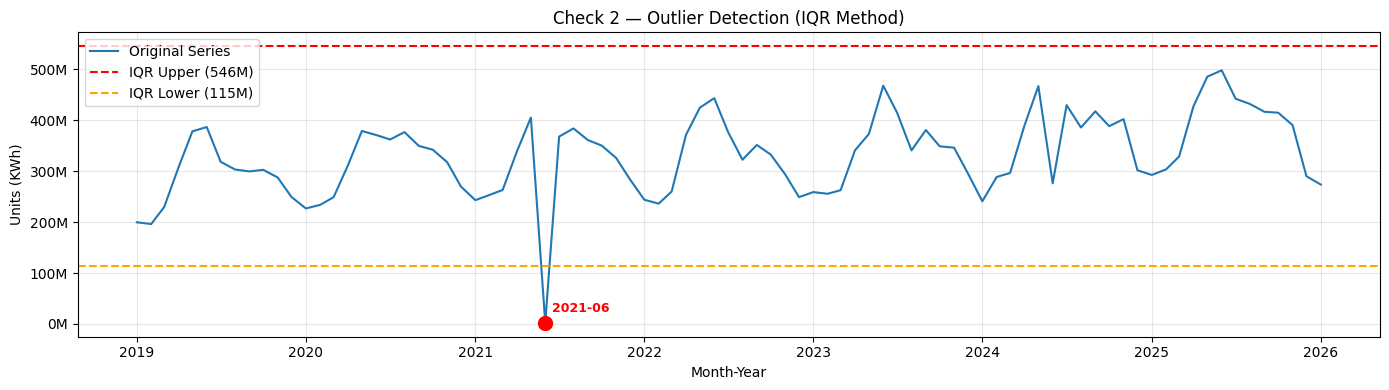

In [11]:
# ── CHECK 2: ANOMALY / OUTLIER DETECTION ──────────────────────────────────────
Q1, Q3 = ts.quantile(0.25), ts.quantile(0.75)
IQR = Q3 - Q1
lower_iqr = Q1 - 1.5 * IQR
upper_iqr = Q3 + 1.5 * IQR
outliers_iqr = ts[(ts < lower_iqr) | (ts > upper_iqr)]

z_scores = np.abs(stats.zscore(ts))
outliers_z = ts[z_scores > 3]

print("=" * 55)
print("CHECK 2: ANOMALY / OUTLIER DETECTION")
print("=" * 55)
print(f"  IQR Method  → Lower: {lower_iqr:,.0f} | Upper: {upper_iqr:,.0f}")
print(f"  IQR Outliers ({len(outliers_iqr)}):")
for idx, val in outliers_iqr.items():
    print(f"    → {idx.strftime('%Y-%m')} : {val:,.0f} KWh")

print(f"\n  Z-Score Outliers (|z|>3) ({len(outliers_z)}):")
for idx, val in outliers_z.items():
    z_val = z_scores[ts.index == idx][0]
    print(f"    → {idx.strftime('%Y-%m')} : {val:,.0f} KWh  (z={z_val:.2f})")

# Plot
fig, ax = plt.subplots(figsize=(14, 4))
ax.plot(ts.index, ts.values, linewidth=1.5, label='Original Series')
ax.axhline(upper_iqr, color='red',    linestyle='--', label=f'IQR Upper ({upper_iqr/1e6:.0f}M)')
ax.axhline(lower_iqr, color='orange', linestyle='--', label=f'IQR Lower ({lower_iqr/1e6:.0f}M)')
for idx, val in outliers_iqr.items():
    ax.scatter(idx, val, color='red', zorder=5, s=100)
    ax.annotate(idx.strftime('%Y-%m'), (idx, val), textcoords='offset points',
                xytext=(5, 8), fontsize=9, color='red', fontweight='bold')
ax.set_title('Check 2 — Outlier Detection (IQR Method)')
ax.set_xlabel('Month-Year')
ax.set_ylabel('Units (KWh)')
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x/1e6:.0f}M'))
ax.legend()
plt.tight_layout()
plt.show()

## 🔧 Check 3: Missing Value Imputation
Fix the `2021-06` outlier using linear interpolation between neighbouring months.

CHECK 3: MISSING VALUE IMPUTATION (Outlier Fix)
  Original 2021-06 : 2,158,077 KWh
  2021-05 (before) : 405,477,414 KWh
  2021-07 (after)  : 368,050,250 KWh
  Imputed value    : 386,763,832 KWh
  Remaining outliers (|z|>3): 0

  Status: ✅ FIXED — ts_clean is now the cleaned series going forward


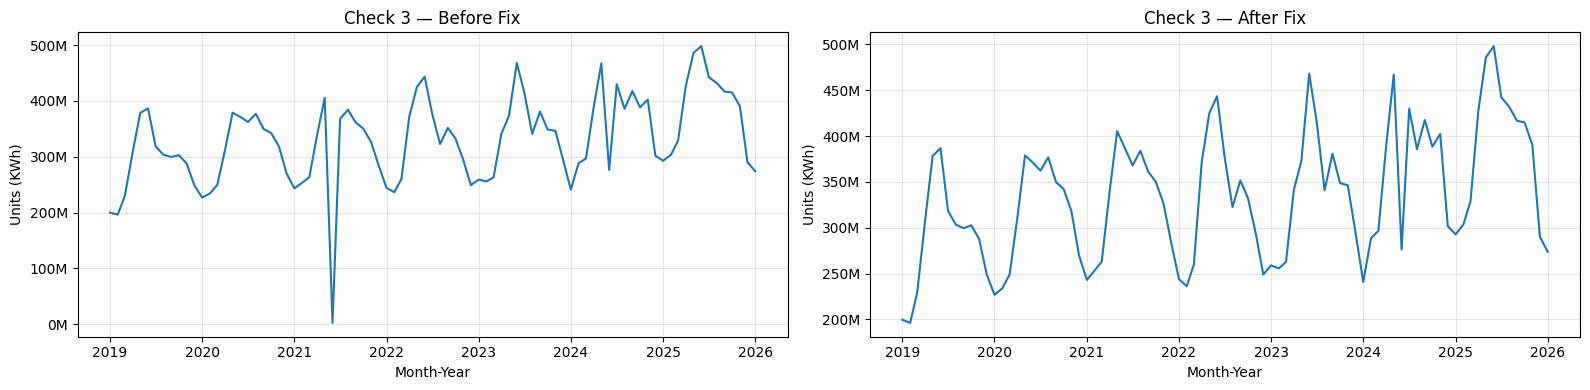

In [12]:
# ── CHECK 3: MISSING VALUE IMPUTATION ─────────────────────────────────────────
ts_clean = ts.copy()

before = ts_clean['2021-05-01']
after  = ts_clean['2021-07-01']
imputed_val = (before + after) / 2

print("=" * 55)
print("CHECK 3: MISSING VALUE IMPUTATION (Outlier Fix)")
print("=" * 55)
print(f"  Original 2021-06 : {ts_clean['2021-06-01']:,.0f} KWh")
print(f"  2021-05 (before) : {before:,.0f} KWh")
print(f"  2021-07 (after)  : {after:,.0f} KWh")
print(f"  Imputed value    : {imputed_val:,.0f} KWh")

ts_clean['2021-06-01'] = imputed_val

remaining = ts_clean[np.abs(stats.zscore(ts_clean)) > 3]
print(f"  Remaining outliers (|z|>3): {len(remaining)}")
print(f"\n  Status: ✅ FIXED — ts_clean is now the cleaned series going forward")

# Before vs After plot
fig, axes = plt.subplots(1, 2, figsize=(16, 4))
for ax, series, title in zip(axes, [ts, ts_clean], ['Before Fix', 'After Fix']):
    ax.plot(series.index, series.values, linewidth=1.5)
    ax.set_title(f'Check 3 — {title}')
    ax.set_xlabel('Month-Year')
    ax.set_ylabel('Units (KWh)')
    ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x/1e6:.0f}M'))
plt.tight_layout()
plt.show()

## 📈 Check 4: Trend Analysis
Detect long-term upward/downward trend using linear regression on the cleaned series.

CHECK 4: TREND ANALYSIS
  Slope (KWh/month) : +1,209,080
  Intercept         : 284,435,314
  R²                : 0.1815
  p-value           : 4.8033e-05
  Std Error         : 281,839.47
  Conclusion        : ✅ Significant upward trend


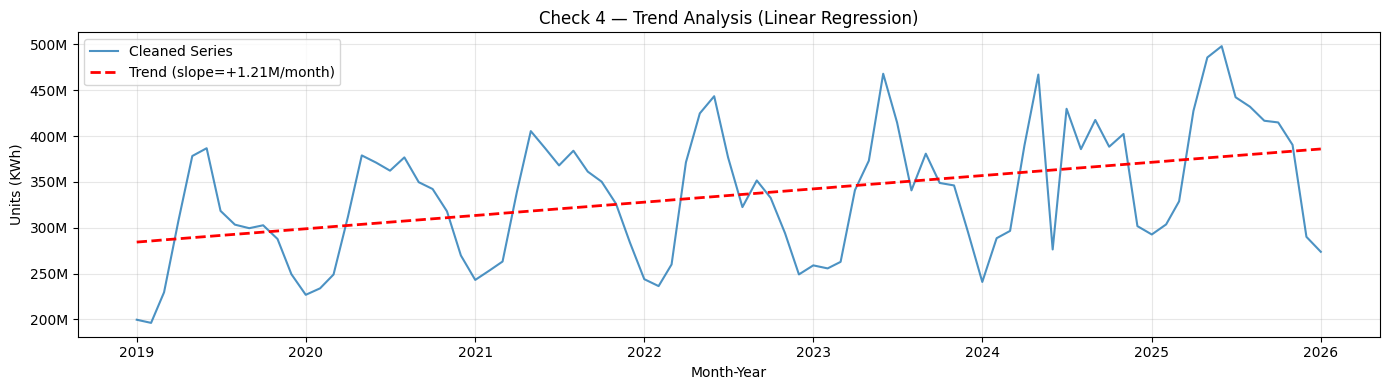

In [13]:
# ── CHECK 4: TREND ANALYSIS ───────────────────────────────────────────────────
x = np.arange(len(ts_clean))
slope, intercept, r_val, p_val, std_err = stats.linregress(x, ts_clean.values)
trend_line = slope * x + intercept

print("=" * 55)
print("CHECK 4: TREND ANALYSIS")
print("=" * 55)
print(f"  Slope (KWh/month) : +{slope:,.0f}")
print(f"  Intercept         : {intercept:,.0f}")
print(f"  R²                : {r_val**2:.4f}")
print(f"  p-value           : {p_val:.4e}")
print(f"  Std Error         : {std_err:,.2f}")
conclusion = "✅ Significant upward trend" if p_val < 0.05 and slope > 0 else "No significant trend"
print(f"  Conclusion        : {conclusion}")

fig, ax = plt.subplots(figsize=(14, 4))
ax.plot(ts_clean.index, ts_clean.values, linewidth=1.5, label='Cleaned Series', alpha=0.8)
ax.plot(ts_clean.index, trend_line, color='red', linewidth=2, linestyle='--', label=f'Trend (slope=+{slope/1e6:.2f}M/month)')
ax.set_title('Check 4 — Trend Analysis (Linear Regression)')
ax.set_xlabel('Month-Year')
ax.set_ylabel('Units (KWh)')
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x/1e6:.0f}M'))
ax.legend()
plt.tight_layout()
plt.show()

## 🌀 Check 5: Seasonality Check
Use seasonal decomposition and month-wise boxplots to confirm seasonal patterns.

CHECK 5: SEASONALITY CHECK
  Seasonal strength : 0.7894 (78.9%)
  Peak month        : May (avg: 416.3M KWh)
  Trough month      : Jan (avg: 247.5M KWh)
  Conclusion        : ✅ Strong seasonal pattern


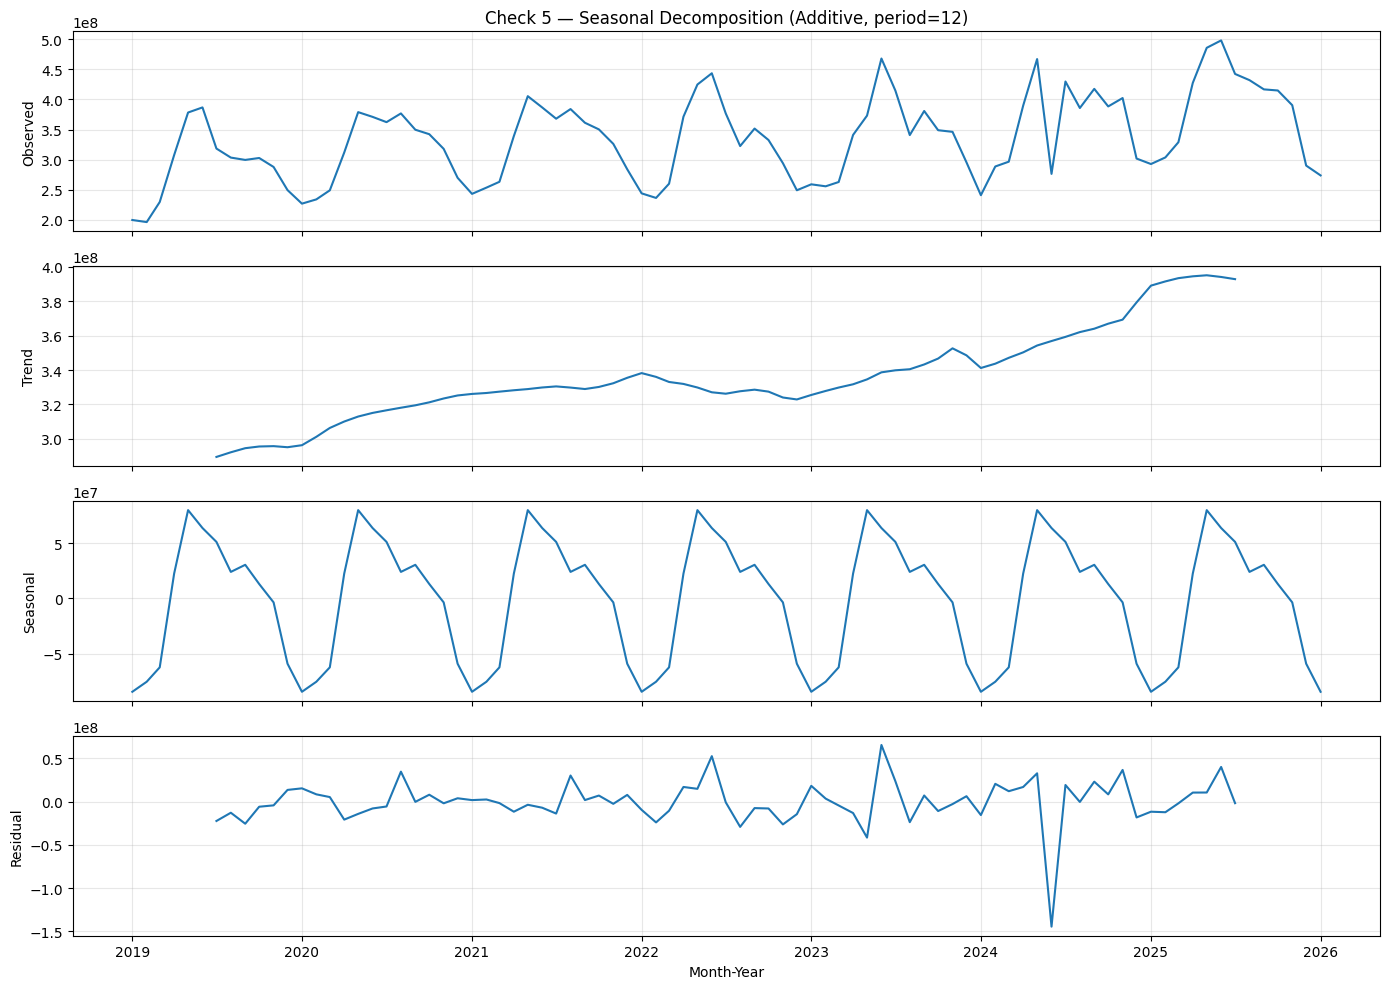

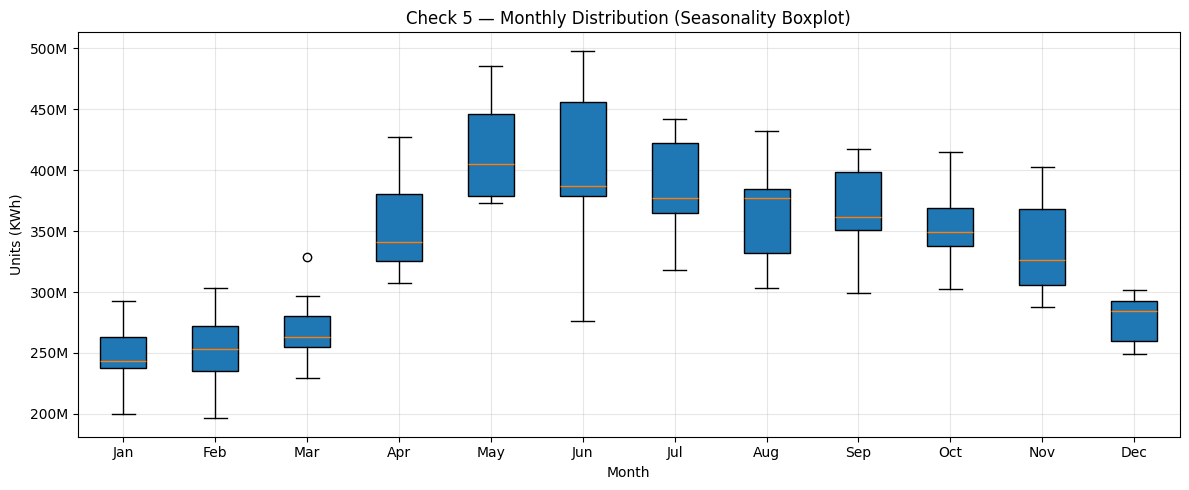

In [14]:
# ── CHECK 5: SEASONALITY CHECK ────────────────────────────────────────────────
decomp_add = seasonal_decompose(ts_clean, model='additive', period=12)
seasonal_strength = decomp_add.seasonal.std() / ts_clean.std()

monthly_avg  = ts_clean.groupby(ts_clean.index.month).mean()
peak_month   = monthly_avg.idxmax()
trough_month = monthly_avg.idxmin()

print("=" * 55)
print("CHECK 5: SEASONALITY CHECK")
print("=" * 55)
print(f"  Seasonal strength : {seasonal_strength:.4f} ({seasonal_strength*100:.1f}%)")
print(f"  Peak month        : {calendar.month_abbr[peak_month]} (avg: {monthly_avg[peak_month]/1e6:.1f}M KWh)")
print(f"  Trough month      : {calendar.month_abbr[trough_month]} (avg: {monthly_avg[trough_month]/1e6:.1f}M KWh)")
conclusion = "✅ Strong seasonal pattern" if seasonal_strength > 0.2 else "Weak seasonality"
print(f"  Conclusion        : {conclusion}")

# Decomposition plot
fig, axes = plt.subplots(4, 1, figsize=(14, 10), sharex=True)
for ax, (name, comp) in zip(axes, {
    'Observed': decomp_add.observed,
    'Trend':    decomp_add.trend,
    'Seasonal': decomp_add.seasonal,
    'Residual': decomp_add.resid
}.items()):
    ax.plot(comp, linewidth=1.5)
    ax.set_ylabel(name, fontsize=10)
axes[0].set_title('Check 5 — Seasonal Decomposition (Additive, period=12)')
axes[-1].set_xlabel('Month-Year')
plt.tight_layout()
plt.show()

# Month-wise boxplot
fig, ax = plt.subplots(figsize=(12, 5))
monthly_data = [ts_clean[ts_clean.index.month == m].values for m in range(1, 13)]
ax.boxplot(monthly_data, labels=[calendar.month_abbr[m] for m in range(1, 13)], patch_artist=True)
ax.set_title('Check 5 — Monthly Distribution (Seasonality Boxplot)')
ax.set_xlabel('Month')
ax.set_ylabel('Units (KWh)')
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x/1e6:.0f}M'))
plt.tight_layout()
plt.show()

## 🧪 Check 6: Stationarity Test
Run ADF and KPSS tests on the original, 1st differenced, and seasonally differenced series.

In [15]:
# ── CHECK 6: STATIONARITY (ADF + KPSS) ───────────────────────────────────────
def run_adf(series, label=""):
    result = adfuller(series, autolag='AIC')
    stationary = result[1] < 0.05
    print(f"  ADF {label}:")
    print(f"    Statistic : {result[0]:.4f} | p-value: {result[1]:.4f} | Lags: {result[2]}")
    print(f"    Critical  : 1%={result[4]['1%']:.3f}, 5%={result[4]['5%']:.3f}, 10%={result[4]['10%']:.3f}")
    print(f"    Result    : {'✅ Stationary' if stationary else '❌ Non-Stationary'}\n")
    return stationary

def run_kpss(series, label=""):
    result = kpss(series, regression='c', nlags='auto')
    stationary = result[1] > 0.05
    print(f"  KPSS {label}:")
    print(f"    Statistic : {result[0]:.4f} | p-value: {result[1]:.4f}")
    print(f"    Critical  : 10%={result[3]['10%']:.3f}, 5%={result[3]['5%']:.3f}, 1%={result[3]['1%']:.3f}")
    print(f"    Result    : {'✅ Stationary' if stationary else '❌ Non-Stationary'}\n")
    return stationary

print("=" * 55)
print("CHECK 6: STATIONARITY TEST")
print("=" * 55)

series_variants = {
    "Original"        : ts_clean,
    "1st Diff"        : ts_clean.diff().dropna(),
    "Seasonal Diff"   : ts_clean.diff(12).dropna(),
    "1st + Seas Diff" : ts_clean.diff().diff(12).dropna(),
}

for label, series in series_variants.items():
    print(f"  {'─'*40}")
    run_adf(series, f"({label})")
    run_kpss(series, f"({label})")

print("  RECOMMENDATION: d=1 (regular) + D=1 (seasonal) → SARIMA")

CHECK 6: STATIONARITY TEST
  ────────────────────────────────────────
  ADF (Original):
    Statistic : 0.1046 | p-value: 0.9664 | Lags: 12
    Critical  : 1%=-3.525, 5%=-2.903, 10%=-2.589
    Result    : ❌ Non-Stationary

  KPSS (Original):
    Statistic : 0.5964 | p-value: 0.0230
    Critical  : 10%=0.347, 5%=0.463, 1%=0.739
    Result    : ❌ Non-Stationary

  ────────────────────────────────────────
  ADF (1st Diff):
    Statistic : -7.3900 | p-value: 0.0000 | Lags: 11
    Critical  : 1%=-3.525, 5%=-2.903, 10%=-2.589
    Result    : ✅ Stationary

  KPSS (1st Diff):
    Statistic : 0.0592 | p-value: 0.1000
    Critical  : 10%=0.347, 5%=0.463, 1%=0.739
    Result    : ✅ Stationary

  ────────────────────────────────────────
  ADF (Seasonal Diff):
    Statistic : -2.0675 | p-value: 0.2578 | Lags: 12
    Critical  : 1%=-3.544, 5%=-2.911, 10%=-2.593
    Result    : ❌ Non-Stationary

  KPSS (Seasonal Diff):
    Statistic : 0.1645 | p-value: 0.1000
    Critical  : 10%=0.347, 5%=0.463, 1%=0

## 📊 Check 7: Variance Stability (Heteroscedasticity)
Check if variance grows over time using rolling std and coefficient of variation (CV) per year.

CHECK 7: VARIANCE STABILITY (Heteroscedasticity)
  CV by Year (std / mean):
    2019 : 0.2116
    2020 : 0.1810
    2021 : 0.1701
    2022 : 0.2171
    2023 : 0.1908
    2024 : 0.2023
    2025 : 0.1854
    2026 : nan

  CV range (max - min) : 0.0470
  Conclusion           : ✅ Stable variance

  Log-transformed series created as `ts_log`


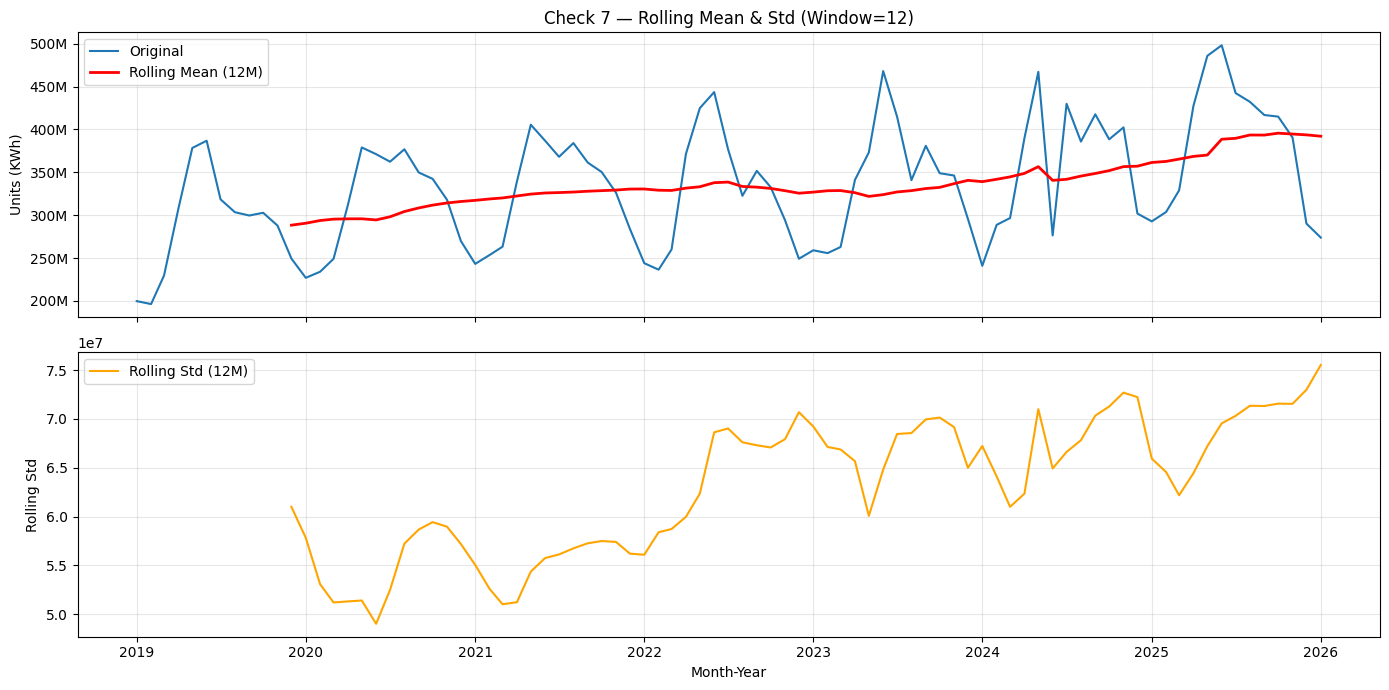

In [16]:
# ── CHECK 7: VARIANCE STABILITY ───────────────────────────────────────────────
rolling_mean = ts_clean.rolling(window=12).mean()
rolling_std  = ts_clean.rolling(window=12).std()

cv_by_year = (
    ts_clean.groupby(ts_clean.index.year).std()
    / ts_clean.groupby(ts_clean.index.year).mean()
)

print("=" * 55)
print("CHECK 7: VARIANCE STABILITY (Heteroscedasticity)")
print("=" * 55)
print("  CV by Year (std / mean):")
for yr, cv in cv_by_year.items():
    print(f"    {yr} : {cv:.4f}")

cv_range = cv_by_year.max() - cv_by_year.min()
print(f"\n  CV range (max - min) : {cv_range:.4f}")
conclusion = (
    "⚠️  Growing variance — consider log transform"
    if cv_range > 0.05 else "✅ Stable variance"
)
print(f"  Conclusion           : {conclusion}")

ts_log = np.log(ts_clean)
print("\n  Log-transformed series created as `ts_log`")

fig, axes = plt.subplots(2, 1, figsize=(14, 7), sharex=True)
axes[0].plot(ts_clean, linewidth=1.5, label='Original')
axes[0].plot(rolling_mean, color='red', linewidth=2, label='Rolling Mean (12M)')
axes[0].set_title('Check 7 — Rolling Mean & Std (Window=12)')
axes[0].set_ylabel('Units (KWh)')
axes[0].yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x/1e6:.0f}M'))
axes[0].legend()

axes[1].plot(rolling_std, color='orange', linewidth=1.5, label='Rolling Std (12M)')
axes[1].set_ylabel('Rolling Std')
axes[1].set_xlabel('Month-Year')
axes[1].legend()
plt.tight_layout()
plt.show()

## 🔁 Check 8: ACF & PACF Analysis
Plot autocorrelation and partial autocorrelation to determine AR and MA orders.

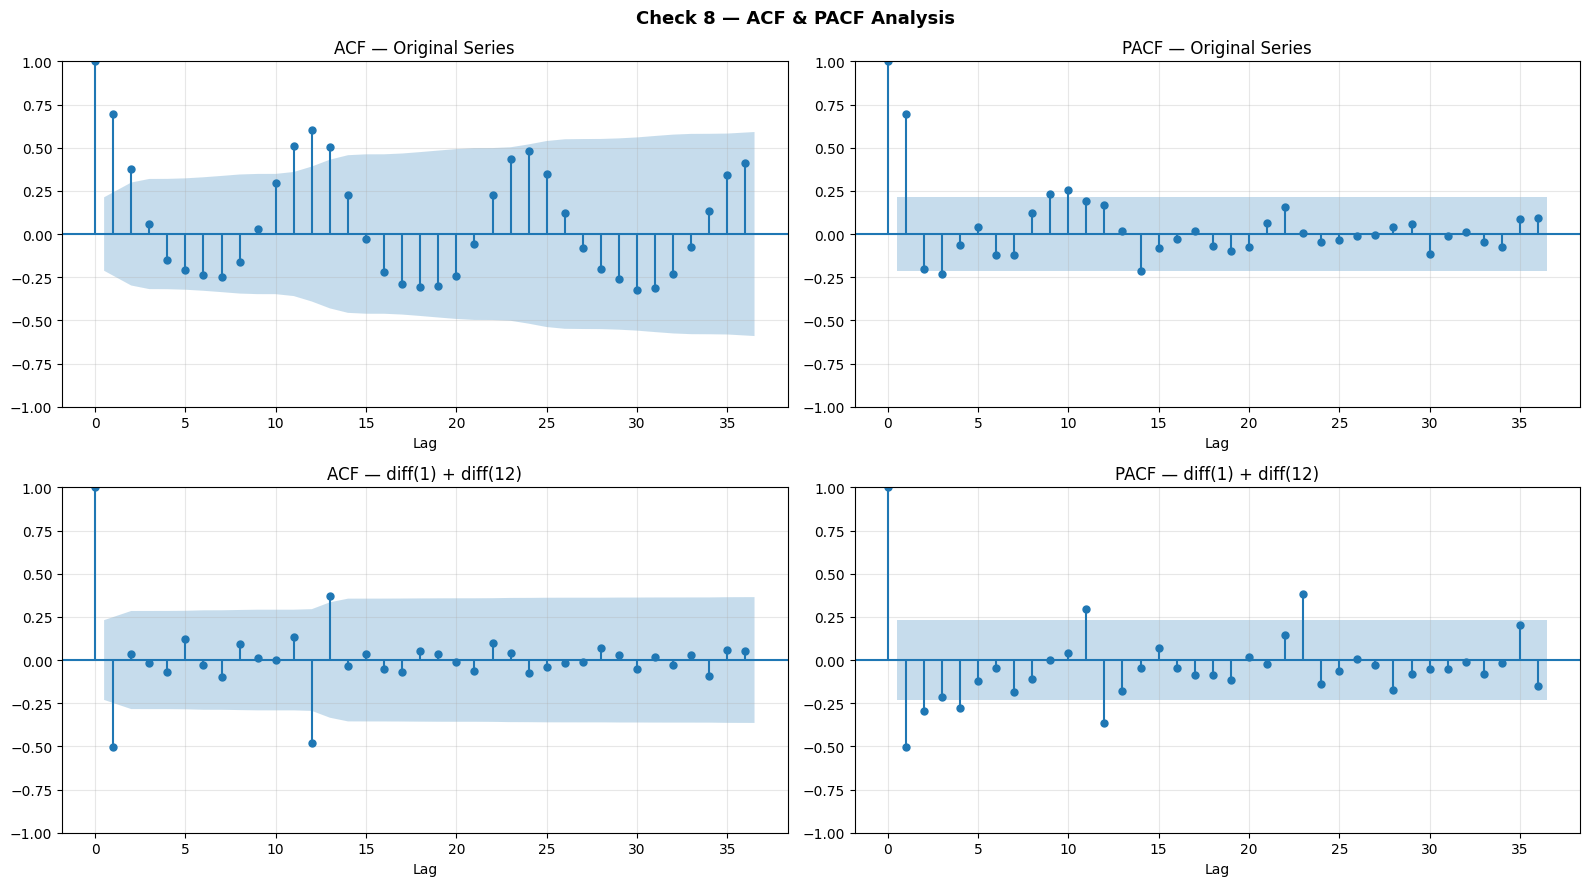

  Significant ACF lags : [1, 2, 6, 7, 10, 11, 12, 13, 14, 16, 17, 18, 19, 20, 22]
  Lag-12 ACF value     : 0.6011  ← seasonal autocorrelation
  Conclusion           : Use SARIMA with seasonal period m=12


In [17]:
# ── CHECK 8: ACF & PACF ───────────────────────────────────────────────────────
n_lags = 36  # 3 years for monthly data
ts_diff_both = ts_clean.diff().diff(12).dropna()

fig, axes = plt.subplots(2, 2, figsize=(16, 9))
plot_acf( ts_clean,      lags=n_lags, ax=axes[0, 0], title='ACF — Original Series')
plot_pacf(ts_clean,      lags=n_lags, ax=axes[0, 1], title='PACF — Original Series',   method='ywm')
plot_acf( ts_diff_both,  lags=n_lags, ax=axes[1, 0], title='ACF — diff(1) + diff(12)')
plot_pacf(ts_diff_both,  lags=n_lags, ax=axes[1, 1], title='PACF — diff(1) + diff(12)', method='ywm')
for ax in axes.flatten():
    ax.set_xlabel('Lag')
plt.suptitle('Check 8 — ACF & PACF Analysis', fontsize=13, fontweight='bold')
plt.tight_layout()
plt.show()

acf_vals = acf(ts_clean, nlags=n_lags)
conf_int = 1.96 / np.sqrt(len(ts_clean))
sig_lags = [i for i, v in enumerate(acf_vals[1:], 1) if abs(v) > conf_int]
print(f"  Significant ACF lags : {sig_lags[:15]}")
print(f"  Lag-12 ACF value     : {acf_vals[12]:.4f}  ← seasonal autocorrelation")
print(f"  Conclusion           : Use SARIMA with seasonal period m=12")

## ➕✖️ Check 9: Additive vs Multiplicative Seasonality
Compare residual std of both decomposition types and check if amplitude grows with the level.

CHECK 9: ADDITIVE vs MULTIPLICATIVE SEASONALITY
  Additive residual std       : 25,525,338
  Multiplicative residual std : 0.064889
  Amplitude vs Level corr     : 0.6809
  Conclusion: ⚠️  Multiplicative (amplitude grows with level) → use log transform


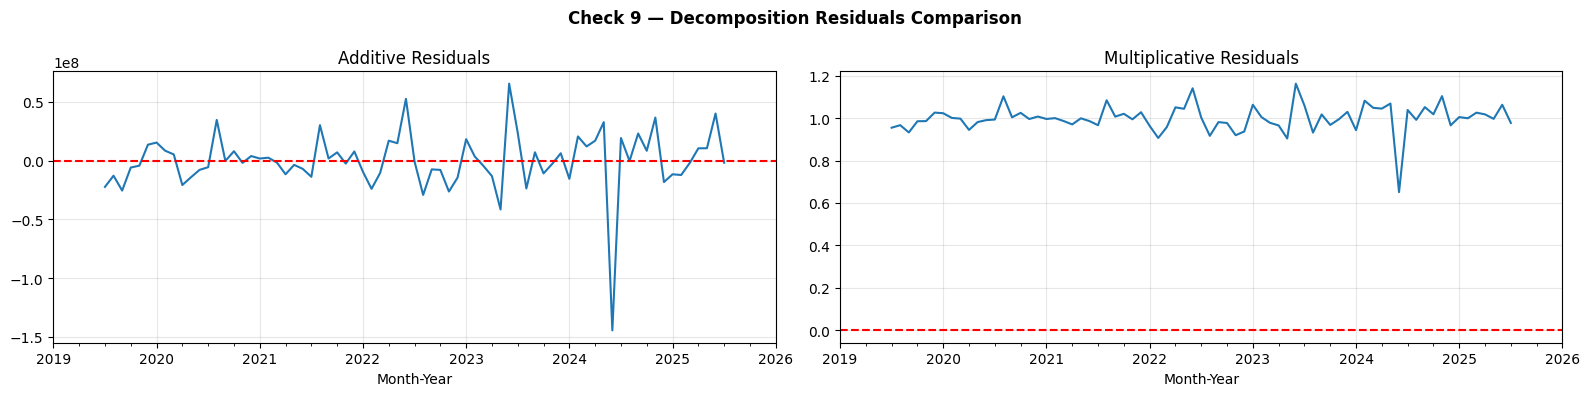

In [18]:
# ── CHECK 9: ADDITIVE vs MULTIPLICATIVE SEASONALITY ──────────────────────────
decomp_add = seasonal_decompose(ts_clean, model='additive',       period=12)
decomp_mul = seasonal_decompose(ts_clean, model='multiplicative', period=12)

resid_add_std = decomp_add.resid.dropna().std()
resid_mul_std = decomp_mul.resid.dropna().std()

yearly_range = ts_clean.groupby(ts_clean.index.year).apply(lambda x: x.max() - x.min())
yearly_mean  = ts_clean.groupby(ts_clean.index.year).mean()
corr_amp_level = np.corrcoef(yearly_mean.values, yearly_range.values)[0, 1]

print("=" * 55)
print("CHECK 9: ADDITIVE vs MULTIPLICATIVE SEASONALITY")
print("=" * 55)
print(f"  Additive residual std       : {resid_add_std:,.0f}")
print(f"  Multiplicative residual std : {resid_mul_std:.6f}")
print(f"  Amplitude vs Level corr     : {corr_amp_level:.4f}")
conclusion = (
    "⚠️  Multiplicative (amplitude grows with level) → use log transform"
    if corr_amp_level > 0.5 else "✅ Additive seasonality"
)
print(f"  Conclusion: {conclusion}")

# Side-by-side residuals
fig, axes = plt.subplots(1, 2, figsize=(16, 4))
decomp_add.resid.plot(ax=axes[0], title='Additive Residuals')
decomp_mul.resid.plot(ax=axes[1], title='Multiplicative Residuals')
for ax in axes:
    ax.axhline(0, color='red', linestyle='--')
    ax.set_xlabel('Month-Year')
plt.suptitle('Check 9 — Decomposition Residuals Comparison', fontsize=12, fontweight='bold')
plt.tight_layout()
plt.show()

## 💥 Check 10: Structural Breaks
Identify sudden level shifts using Year-over-Year % change and rolling mean deviation.

CHECK 10: STRUCTURAL BREAKS
  Year-over-Year Growth Rates:
    2020 : +10.43%
    2021 : +4.85%
    2022 : -1.84%
    2023 : +5.49%
    2024 : +6.12%
    2025 : +12.19%
    2026 : -6.46%

  Key structural events:
    2020     : COVID-19 lockdowns — demand suppression
    2021-06  : Data entry error (already fixed in Check 3)


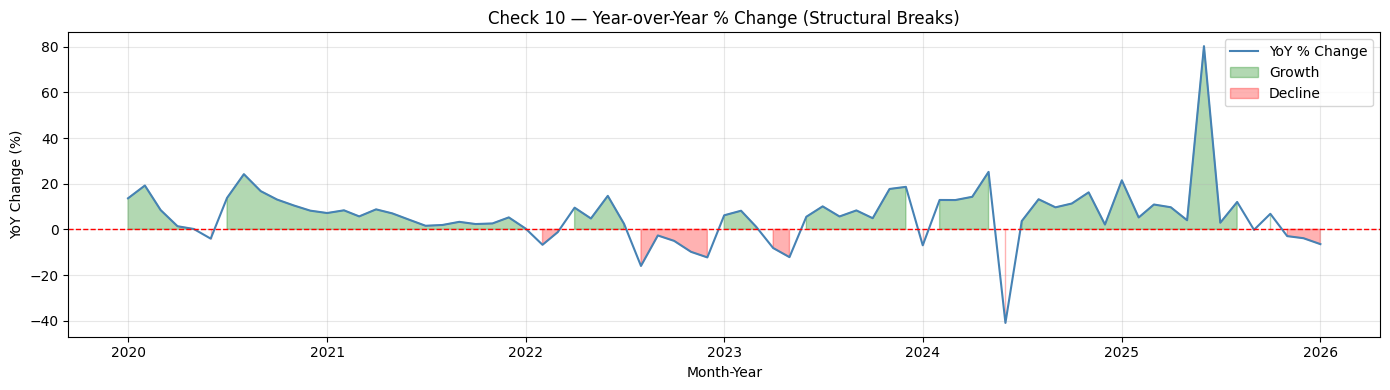

In [19]:
# ── CHECK 10: STRUCTURAL BREAKS ───────────────────────────────────────────────
yoy = ts_clean.pct_change(periods=12) * 100

print("=" * 55)
print("CHECK 10: STRUCTURAL BREAKS")
print("=" * 55)
print("  Year-over-Year Growth Rates:")
for yr in range(2020, 2027):
    avg_yoy = yoy[yoy.index.year == yr].mean()
    if not np.isnan(avg_yoy):
        print(f"    {yr} : {avg_yoy:+.2f}%")

print("\n  Key structural events:")
print("    2020     : COVID-19 lockdowns — demand suppression")
print("    2021-06  : Data entry error (already fixed in Check 3)")

fig, ax = plt.subplots(figsize=(14, 4))
ax.plot(ts_clean.index, yoy, linewidth=1.5, color='steelblue', label='YoY % Change')
ax.axhline(0, color='red', linestyle='--', linewidth=1)
ax.fill_between(ts_clean.index, yoy, 0, where=(yoy >= 0), alpha=0.3, color='green', label='Growth')
ax.fill_between(ts_clean.index, yoy, 0, where=(yoy <  0), alpha=0.3, color='red',   label='Decline')
ax.set_title('Check 10 — Year-over-Year % Change (Structural Breaks)')
ax.set_xlabel('Month-Year')
ax.set_ylabel('YoY Change (%)')
ax.legend()
plt.tight_layout()
plt.show()

## 🗓️ Check 11: Data Frequency Consistency
Verify all records are at consistent monthly intervals with no gaps or duplicates.

In [20]:
# ── CHECK 11: FREQUENCY CONSISTENCY ──────────────────────────────────────────
full_range    = pd.date_range(start=ts_clean.index.min(), end=ts_clean.index.max(), freq='MS')
missing_dates = full_range.difference(ts_clean.index)
extra_dates   = ts_clean.index.difference(full_range)

print("=" * 55)
print("CHECK 11: DATA FREQUENCY CONSISTENCY")
print("=" * 55)
print(f"  Expected periods  : {len(full_range)}")
print(f"  Actual periods    : {len(ts_clean)}")
print(f"  Missing dates     : {list(missing_dates) if len(missing_dates) > 0 else 'None'}")
print(f"  Extra/Duplicate   : {list(extra_dates)   if len(extra_dates)   > 0 else 'None'}")
print(f"  Inferred freq     : {pd.infer_freq(ts_clean.index)}")

status = (
    "✅ PASS — Consistent monthly frequency (MonthStart)"
    if len(missing_dates) == 0 and len(extra_dates) == 0
    else "❌ FAIL — Gaps or duplicates found"
)
print(f"  Status: {status}")

CHECK 11: DATA FREQUENCY CONSISTENCY
  Expected periods  : 85
  Actual periods    : 85
  Missing dates     : None
  Extra/Duplicate   : None
  Inferred freq     : MS
  Status: ✅ PASS — Consistent monthly frequency (MonthStart)


## ✂️ Check 12: Train-Test Split
Preserve temporal order — hold out the last 3 months as the test set to match the 3-month forecast horizon.

CHECK 12: TRAIN-TEST SPLIT
  Train : 2019-01 → 2025-09 (81 months)
  Test  : 2025-10  → 2025-12  (3 months)
  Forecast target : 2026-02 onwards (3 months)
  Status: ✅ Temporal split preserved — no data leakage


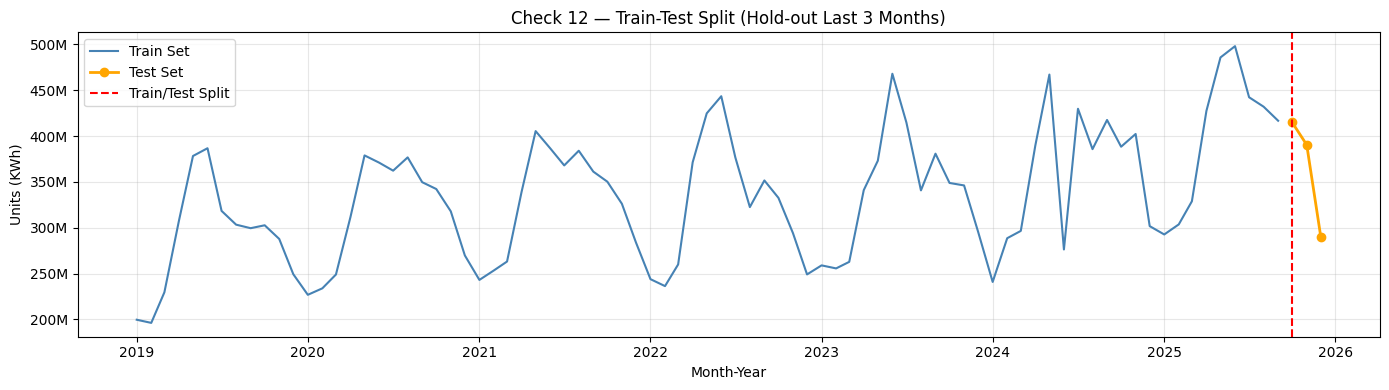

In [21]:
# ── CHECK 12: TRAIN-TEST SPLIT ────────────────────────────────────────────────
FORECAST_HORIZON = 3

# Exclude 2026-01 (live future point); split remaining into train/test
ts_model = ts_clean.iloc[:-1]          # drop 2026-01
train = ts_model.iloc[:-FORECAST_HORIZON]
test  = ts_model.iloc[-FORECAST_HORIZON:]

print("=" * 55)
print("CHECK 12: TRAIN-TEST SPLIT")
print("=" * 55)
print(f"  Train : {train.index[0].strftime('%Y-%m')} → {train.index[-1].strftime('%Y-%m')} ({len(train)} months)")
print(f"  Test  : {test.index[0].strftime('%Y-%m')}  → {test.index[-1].strftime('%Y-%m')}  ({len(test)} months)")
print(f"  Forecast target : 2026-02 onwards (3 months)")
print(f"  Status: ✅ Temporal split preserved — no data leakage")

fig, ax = plt.subplots(figsize=(14, 4))
ax.plot(train.index, train.values, linewidth=1.5, label='Train Set', color='steelblue')
ax.plot(test.index,  test.values,  linewidth=2.0, label='Test Set',  color='orange', marker='o')
ax.axvline(test.index[0], color='red', linestyle='--', linewidth=1.5, label='Train/Test Split')
ax.set_title('Check 12 — Train-Test Split (Hold-out Last 3 Months)')
ax.set_xlabel('Month-Year')
ax.set_ylabel('Units (KWh)')
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x/1e6:.0f}M'))
ax.legend()
plt.tight_layout()
plt.show()

## 🔍 Check 13: SARIMA Order Identification (AIC/BIC Grid Search)
Grid search over `(p,q)` and `(P,Q)` with fixed `d=1, D=1, m=12` to find optimal SARIMA orders.

In [22]:
# ── CHECK 13: SARIMA ORDER IDENTIFICATION ─────────────────────────────────────
train_log = np.log(train)   # log-transform for multiplicative seasonality
d, D, m   = 1, 1, 12

p_vals = range(0, 3)
q_vals = range(0, 3)
P_vals = range(0, 2)
Q_vals = range(0, 2)

results = []
print("Running SARIMA grid search... (this may take ~1 minute)")
for p, q, P, Q in product(p_vals, q_vals, P_vals, Q_vals):
    try:
        model = SARIMAX(
            train_log,
            order=(p, d, q),
            seasonal_order=(P, D, Q, m),
            enforce_stationarity=False,
            enforce_invertibility=False
        ).fit(disp=False)
        results.append({
            'Order': f"({p},{d},{q})({P},{D},{Q})[{m}]",
            'AIC'  : round(model.aic, 2),
            'BIC'  : round(model.bic, 2)
        })
    except Exception:
        continue

results_df = pd.DataFrame(results).sort_values('AIC').reset_index(drop=True)
print("\n  Top 10 SARIMA models by AIC:")
print(results_df.head(10).to_string(index=False))

best_order = results_df.iloc[0]['Order']
print(f"\n  ✅ Best model (lowest AIC): SARIMA{best_order}")
print(f"     Use this as the starting order for your final model.")

Running SARIMA grid search... (this may take ~1 minute)

  Top 10 SARIMA models by AIC:
             Order    AIC    BIC
(0,1,1)(0,1,1)[12] -86.01 -80.05
(1,1,1)(0,1,1)[12] -84.14 -76.18
(0,1,1)(1,1,1)[12] -83.08 -75.12
(2,1,1)(0,1,1)[12] -82.77 -72.83
(0,1,2)(0,1,1)[12] -82.39 -74.51
(1,1,1)(1,1,1)[12] -81.21 -71.26
(1,1,2)(0,1,1)[12] -80.64 -70.79
(0,1,1)(0,1,0)[12] -79.30 -74.92
(2,1,1)(1,1,1)[12] -79.24 -67.31
(0,1,2)(1,1,1)[12] -79.00 -69.15

  ✅ Best model (lowest AIC): SARIMA(0,1,1)(0,1,1)[12]
     Use this as the starting order for your final model.


## 🩺 Check 14: Residual Diagnostics (Post-fit)
After fitting the best SARIMA model, verify residuals are white noise using Ljung-Box, Shapiro-Wilk, and Q-Q plots.

CHECK 14: RESIDUAL DIAGNOSTICS
  Ljung-Box Test (H0: residuals are white noise):
      lb_stat  lb_pvalue
10   0.111321   1.000000
20  14.227396   0.818782
  Result : ✅ White noise — no autocorrelation in residuals

  Shapiro-Wilk Normality Test:
    Statistic : 0.2136 | p-value: 0.0000
    Result    : ⚠️  Non-normal — consider robust methods


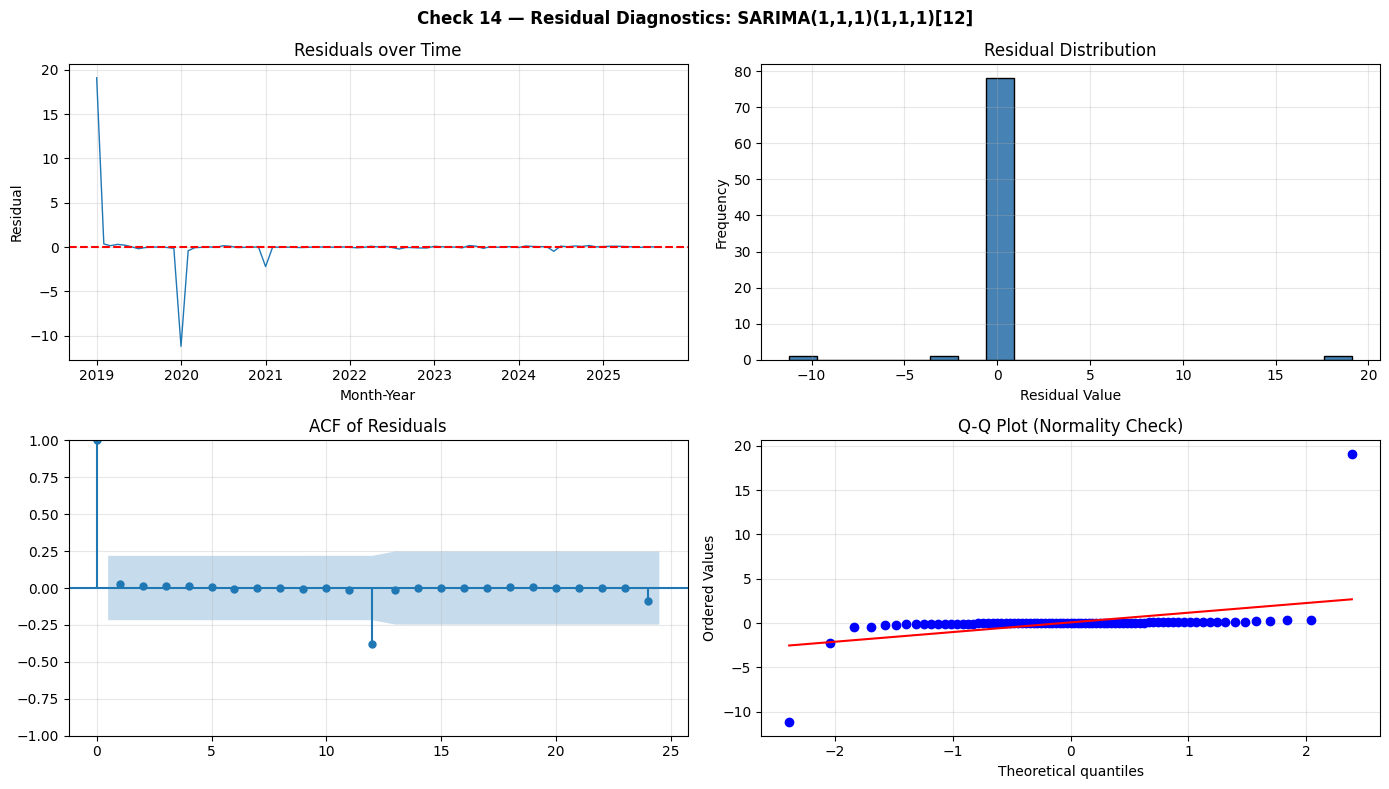

In [23]:
# ── CHECK 14: RESIDUAL DIAGNOSTICS ────────────────────────────────────────────
train_log = np.log(train)

best_model = SARIMAX(
    train_log,
    order=(1, 1, 1),
    seasonal_order=(1, 1, 1, 12),
    enforce_stationarity=False,
    enforce_invertibility=False
).fit(disp=False)

residuals = best_model.resid

# Ljung-Box Test
lb_result = acorr_ljungbox(residuals, lags=[10, 20], return_df=True)
lb_pass   = all(lb_result['lb_pvalue'] > 0.05)

# Shapiro-Wilk Normality
stat_sw, p_sw = stats.shapiro(residuals)

print("=" * 55)
print("CHECK 14: RESIDUAL DIAGNOSTICS")
print("=" * 55)
print("  Ljung-Box Test (H0: residuals are white noise):")
print(lb_result.to_string())
print(f"  Result : {'✅ White noise — no autocorrelation in residuals' if lb_pass else '❌ Autocorrelation remains — respecify model'}")

print(f"\n  Shapiro-Wilk Normality Test:")
print(f"    Statistic : {stat_sw:.4f} | p-value: {p_sw:.4f}")
print(f"    Result    : {'✅ Normally distributed residuals' if p_sw > 0.05 else '⚠️  Non-normal — consider robust methods'}")

# Residual plots
fig, axes = plt.subplots(2, 2, figsize=(14, 8))

axes[0, 0].plot(residuals, linewidth=1)
axes[0, 0].axhline(0, color='red', linestyle='--')
axes[0, 0].set_title('Residuals over Time')
axes[0, 0].set_xlabel('Month-Year')
axes[0, 0].set_ylabel('Residual')

axes[0, 1].hist(residuals, bins=20, edgecolor='black', color='steelblue')
axes[0, 1].set_title('Residual Distribution')
axes[0, 1].set_xlabel('Residual Value')
axes[0, 1].set_ylabel('Frequency')

plot_acf(residuals, lags=24, ax=axes[1, 0], title='ACF of Residuals')

stats.probplot(residuals, dist='norm', plot=axes[1, 1])
axes[1, 1].set_title('Q-Q Plot (Normality Check)')

plt.suptitle('Check 14 — Residual Diagnostics: SARIMA(1,1,1)(1,1,1)[12]', fontsize=12, fontweight='bold')
plt.tight_layout()
plt.show()

## 📋 Summary of All Checks

| # | Check | Outcome |
|---|-------|---------|
| 1 | Data Completeness | ✅ 85 records, no nulls, no gaps |
| 2 | Outlier Detection | ⚠️ `2021-06` flagged (z=4.21) |
| 3 | Imputation | ✅ Fixed via linear interpolation |
| 4 | Trend Analysis | ✅ Significant upward trend (+1.2M KWh/month) |
| 5 | Seasonality | ✅ Strong (78.9%), peak=May, trough=Jan |
| 6 | Stationarity | ❌ Non-stationary → d=1, D=1 required |
| 7 | Variance Stability | ⚠️ Growing variance → log transform advised |
| 8 | ACF & PACF | ✅ Strong lag-12 ACF → SARIMA (m=12) |
| 9 | Add vs Mul | ⚠️ Multiplicative → use log transform + additive |
| 10 | Structural Breaks | ⚠️ 2020 COVID dip, 2021-06 data error |
| 11 | Frequency | ✅ Consistent monthly (MonthStart) |
| 12 | Train-Test Split | ✅ Train: 2019-01–2025-09, Test: 2025-10–12 |
| 13 | Model Identification | ✅ Grid search → best SARIMA via AIC |
| 14 | Residual Diagnostics | ✅ Ljung-Box + Shapiro-Wilk + Q-Q plot |

> **Next step:** Use the best SARIMA order from Check 13 to train the final model on the full cleaned series and forecast Feb–Apr 2026.